### PHÁT HIỆN CÁC ĐIỂM BẤT THƯỜNG

In [1]:
#Import thư viện
import pandas as pd
import numpy as np
import os
import glob
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#### Phương pháp 1: Dựa trên thống kê(Z_score)

In [2]:
import pandas as pd
import os

def detect_anomalies_by_zscore(csv_path, city_name, threshold_aqi=3.0, threshold_wind=3.0):
    df = pd.read_csv(csv_path)

    # Tính Z-score cho AQI
    aqi_mean = df["aqi"].mean()
    aqi_std = df["aqi"].std()
    df["zscore_aqi"] = (df["aqi"] - aqi_mean) / aqi_std
    df["zscore_flag_aqi"] = df["zscore_aqi"].abs().apply(lambda z: -1 if z > threshold_aqi else 0)

    # Tính Z-score cho Wind
    df["wind_speed_clean"] = df["wind_speed"].astype(str).str.extract(r"([\d.]+)").astype(float)
    wind_mean = df["wind_speed_clean"].mean()
    wind_std = df["wind_speed_clean"].std()
    df["zscore_wind"] = (df["wind_speed_clean"] - wind_mean) / wind_std
    df["zscore_flag_wind"] = df["zscore_wind"].abs().apply(lambda z: -1 if z > threshold_wind else 0)

    # Giữ lại các cột cần thiết để lưu file
    keep_cols = [col for col in df.columns if col not in ["wind_speed_clean"]]
    df_clean = df[keep_cols]

    # Lưu kết quả
    base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Từ thư mục hiện tại → lên thư mục gốc Anomaly-Detection-System
    output_dir = os.path.join(base_dir, "result_anomaly", "z_score")  # Tạo đường dẫn tới thư mục z_score
    os.makedirs(output_dir, exist_ok=True)

    output_path = os.path.join(output_dir, f"{city_name.lower().replace(' ', '_')}_zscore.csv")  # Tên file theo tên thành phố
    df_clean.to_csv(output_path, index=False, encoding='utf-8-sig')


    # Đếm số điểm bất thường
    aqi_anomalies = (df_clean["zscore_flag_aqi"] == -1).sum()
    wind_anomalies = (df_clean["zscore_flag_wind"] == -1).sum()

    print(f"{city_name}: Phát hiện {aqi_anomalies} điểm bất thường AQI, {wind_anomalies} điểm bất thường gió.")

    return df_clean


if __name__ == "__main__":
    city_file_map = {
        "Can_Tho": "../result/aqi-can-tho_2025.csv",
        "Da_Nang": "../result/aqi-da-nang_2025.csv",
        "Hai_Phong": "../result/aqi-hai-phong_2025.csv",
        "Ha_Noi": "../result/aqi-hanoi_2025.csv",
        "Ho_Chi_Minh": "../result/aqi-ho-chi-minh-city_2025.csv",
        "Hue": "../result/aqi-hue_2025.csv",
        "Nha_Trang": "../result/aqi-nha-trang_2025.csv",
        "Vinh": "../result/aqi-vinh_2025.csv",
    }

    for city, file_path in city_file_map.items():
        if os.path.exists(file_path):
            detect_anomalies_by_zscore(file_path, city)
        else:
            print(f"Không tìm thấy file: {file_path} → Bỏ qua {city}")

Can_Tho: Phát hiện 48 điểm bất thường AQI, 36 điểm bất thường gió.
Da_Nang: Phát hiện 66 điểm bất thường AQI, 36 điểm bất thường gió.
Hai_Phong: Phát hiện 8 điểm bất thường AQI, 34 điểm bất thường gió.
Ha_Noi: Phát hiện 5 điểm bất thường AQI, 24 điểm bất thường gió.
Ho_Chi_Minh: Phát hiện 85 điểm bất thường AQI, 35 điểm bất thường gió.


Hue: Phát hiện 82 điểm bất thường AQI, 62 điểm bất thường gió.
Nha_Trang: Phát hiện 201 điểm bất thường AQI, 32 điểm bất thường gió.
Vinh: Phát hiện 27 điểm bất thường AQI, 37 điểm bất thường gió.


#### Phương pháp 2: Dựa trên học máy(Isolation Forest)

In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import IsolationForest

def detect_anomalies(city_data_path, city_name):
    # 1. Đọc dữ liệu
    try:
        df = pd.read_csv(city_data_path)
    except FileNotFoundError:
        print(f"Không tìm thấy file {city_data_path}. Bỏ qua {city_name}.")
        return
    except Exception as e:
        print(f"Lỗi đọc file {city_data_path}: {e}")
        return

    # 2. Tiền xử lý
    if 'AQI' not in df.columns and 'aqi' in df.columns:
        df.rename(columns={'aqi': 'AQI'}, inplace=True)

    if 'wind_speed' in df.columns:
        df['wind_speed'] = df['wind_speed'].astype(str).str.replace(' km/h', '').replace('', np.nan)
        df['wind_speed'] = pd.to_numeric(df['wind_speed'], errors='coerce')

    if 'humidity' in df.columns:
        df['humidity'] = df['humidity'].astype(str).str.replace('%', '').replace('', np.nan)
        df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')

    if 'AQI' not in df.columns:
        print(f"Dữ liệu {city_name} không có cột AQI. Bỏ qua.")
        return

    # 3. Chọn dữ liệu đầu vào
    if 'wind_speed' not in df.columns or 'humidity' not in df.columns:
        X = df[['AQI']].values
    else:
        X = df[['AQI', 'wind_speed', 'humidity']].values

    mask = ~np.any(np.isnan(X), axis=1)
    X = X[mask]
    df = df[mask].reset_index(drop=True)

    if len(X) == 0:
        print(f"Dữ liệu {city_name} bị trống sau xử lý.")
        return

    # 4. Xác định contamination
    aqi_std = df['AQI'].std()
    wind_std = df['wind_speed'].std()
    hum_std = df['humidity'].std()
    combined_std = 0.5 * aqi_std + 0.25 * wind_std + 0.25 * hum_std
    contamination = min(0.1, max(0.01, combined_std / 200))  # Giới hạn từ 1% đến 10%

    # 5. Mô hình Isolation Forest
    model = IsolationForest(contamination=contamination, random_state=42)
    predictions = model.fit_predict(X)
    df['anomaly'] = predictions

    # 6. Kết quả
    anomalies = df[df['anomaly'] == -1]
    print(f"{city_name}: Phát hiện {len(anomalies)} điểm bất thường.")

    # 7. Lưu kết quả bằng đường dẫn tương đối
    base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Từ detection → Anomaly-Detection-System
    output_dir = os.path.join(base_dir, "result_anomaly", "isolation_forest")
    os.makedirs(output_dir, exist_ok=True)

    output_file = os.path.join(output_dir, f"anomalies_{city_name.lower().replace(' ', '_')}_2025.csv")
    df.to_csv(output_file, index=False, encoding='utf-8-sig')
cities = {
    "Can_Tho": "../result/aqi-can-tho_2025.csv",
    "Da_Nang": "../result/aqi-da-nang_2025.csv",
    "Hai_Phong": "../result/aqi-hai-phong_2025.csv",
    "Ha_Noi": "../result/aqi-hanoi_2025.csv",
    "Ho_Chi_Minh": "../result/aqi-ho-chi-minh-city_2025.csv",
    "Hue": "../result/aqi-hue_2025.csv",
    "Nha_Trang": "../result/aqi-nha-trang_2025.csv",
    "Vinh": "../result/aqi-vinh_2025.csv",
}

for city_name, file_path in cities.items():
    detect_anomalies(file_path, city_name)

Can_Tho: Phát hiện 403 điểm bất thường.
Da_Nang: Phát hiện 397 điểm bất thường.


Hai_Phong: Phát hiện 465 điểm bất thường.
Ha_Noi: Phát hiện 407 điểm bất thường.


Ho_Chi_Minh: Phát hiện 356 điểm bất thường.
Hue: Phát hiện 346 điểm bất thường.


Nha_Trang: Phát hiện 232 điểm bất thường.
Vinh: Phát hiện 465 điểm bất thường.


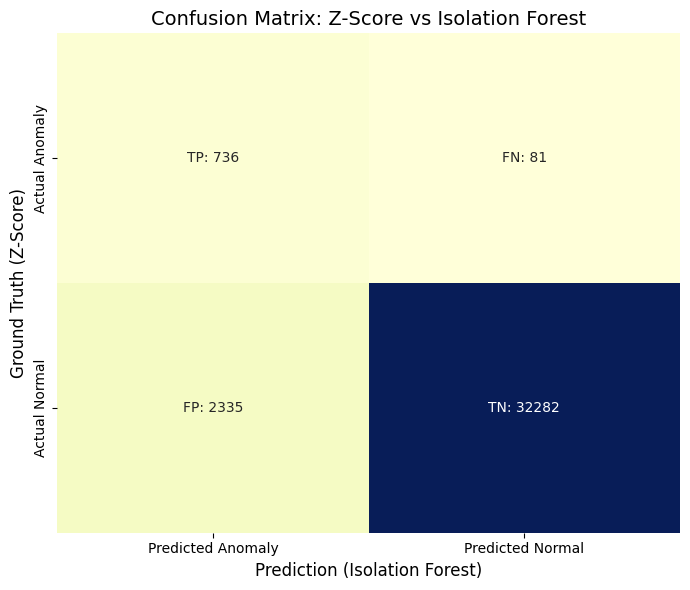

In [4]:
# Danh sách các file theo thành phố
cities = [
    ("Can Tho", "../result_anomaly/z_score/can_tho_zscore.csv", "../result_anomaly/isolation_forest/anomalies_can_tho_2025.csv"),
    ("Hai Phong", "../result_anomaly/z_score/hai_phong_zscore.csv", "../result_anomaly/isolation_forest/anomalies_hai_phong_2025.csv"),
    ("Ho Chi Minh", "../result_anomaly/z_score/ho_chi_minh_zscore.csv", "../result_anomaly/isolation_forest/anomalies_ho_chi_minh_2025.csv"),
    ("Vinh", "../result_anomaly/z_score/vinh_zscore.csv", "../result_anomaly/isolation_forest/anomalies_vinh_2025.csv"),
    ("Nha Trang", "../result_anomaly/z_score/nha_trang_zscore.csv", "../result_anomaly/isolation_forest/anomalies_nha_trang_2025.csv"),
    ("Da Nang", "../result_anomaly/z_score/da_nang_zscore.csv", "../result_anomaly/isolation_forest/anomalies_da_nang_2025.csv"),
    ("Ha Noi", "../result_anomaly/z_score/ha_noi_zscore.csv", "../result_anomaly/isolation_forest/anomalies_ha_noi_2025.csv"),
    ("Hue", "../result_anomaly/z_score/hue_zscore.csv", "../result_anomaly/isolation_forest/anomalies_hue_2025.csv"),
]

# Gộp nhãn các thành phố
zscore_labels_all = []
iforest_labels_all = []

for _, zscore_path, iforest_path in cities:
    if os.path.exists(zscore_path) and os.path.exists(iforest_path):
        df_z = pd.read_csv(zscore_path)
        df_if = pd.read_csv(iforest_path)

        zscore_labels = ((df_z['zscore_flag_aqi'] == -1) | (df_z['zscore_flag_wind'] == -1)).astype(int)
        iforest_labels = (df_if['anomaly'] == -1).astype(int)

        min_len = min(len(zscore_labels), len(iforest_labels))
        zscore_labels_all.extend(zscore_labels[:min_len])
        iforest_labels_all.extend(iforest_labels[:min_len])

# Tính confusion matrix
cm = confusion_matrix(zscore_labels_all, iforest_labels_all, labels=[1, 0])

# Gán nhãn rõ ràng: TP, FN, FP, TN
labels = ["Actual Anomaly", "Actual Normal"]
columns = ["Predicted Anomaly", "Predicted Normal"]
df_cm = pd.DataFrame(cm, index=labels, columns=columns)

# Tạo chú thích rõ ràng
annot_labels = [
    [f"TP: {cm[0][0]}", f"FN: {cm[0][1]}"],
    [f"FP: {cm[1][0]}", f"TN: {cm[1][1]}"]
]

# Vẽ heatmap dễ hiểu
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=annot_labels, fmt='', cmap='YlGnBu', xticklabels=columns, yticklabels=labels, cbar=False)
plt.title("Confusion Matrix: Z-Score vs Isolation Forest", fontsize=14)
plt.ylabel("Ground Truth (Z-Score)", fontsize=12)
plt.xlabel("Prediction (Isolation Forest)", fontsize=12)
plt.tight_layout()
plt.show()

In [5]:
def get_latest_files(result_dir, pattern="aqi_*.csv"):
    return glob.glob(os.path.join(result_dir, pattern))

def extract_city_name(file_path):
    base = os.path.basename(file_path)
    parts = base.replace(".csv", "").split("_")
    return "_".join(parts[1:-1])  # Loại bỏ 'aqi' và '2025'

In [6]:
result_dir = os.path.join(os.getcwd(), "result")
latest_files = get_latest_files(result_dir)

for file_path in latest_files:
    city_name = extract_city_name(file_path).replace("_", " ").title()
    print(f"\nPhân tích dữ liệu: {city_name}")
    detect_anomalies_by_zscore(file_path, city_name)
    detect_anomalies(file_path, city_name)